In [1]:
# installs & imports
!pip install -q torch torchvision tqdm einops

import math, os, random, time
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import LambdaLR
from torchvision.transforms import AutoAugmentPolicy

from einops import rearrange

In [2]:
# config
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device)

cfg = {
    "image_size": 32,
    "patch_size": 4,
    "in_channels": 3,
    "num_classes": 100,
    "emb_dim": 384,     # smaller, regularizes better
    "num_heads": 6,
    "depth": 8,
    "mlp_ratio": 4.0,
    "drop": 0.1,
    "drop_path": 0.1,   # stochastic depth (important)
    "batch_size": 128,
    "epochs": 200,      # 200–300 is enough with cosine LR
    "lr": 3e-4,
    "weight_decay": 0.05,
    "warmup_epochs": 5,
    "label_smoothing": 0.1,
    "ema_decay": 0.9999,
    "seed": 42
}

device: mps


In [3]:
# reproducibility
torch.manual_seed(cfg["seed"])
random.seed(cfg["seed"])

In [4]:
# Dataset
mean = (0.5071, 0.4867, 0.4408)
std  = (0.2675, 0.2565, 0.2761)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.AutoAugment(policy=AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),  # Move ToTensor before RandomErasing
    transforms.RandomErasing(p=0.25, value='random'),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.CIFAR100(root="data", train=True, download=True, transform=train_transform)
test_ds  = datasets.CIFAR100(root="data", train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=cfg["batch_size"], shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

In [5]:
# ViT model implementation

# Conv stem 
class ConvPatchEmbed(nn.Module):
    def __init__(self, in_chans=3, embed_dim=384):
        super().__init__()
        # Input 32x32 -> conv1: 32x32 -> conv2 stride2 -> 16x16 -> conv3 stride2 -> 8x8
        self.conv = nn.Sequential(
            nn.Conv2d(in_chans, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, embed_dim, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(inplace=True),
        )
        # n_patches = (32/4)^2 = 8*8 = 64
        self.n_patches = (32 // 4) ** 2

    def forward(self, x):
        # x: (B, C, H, W)
        x = self.conv(x)                  # (B, E, H/4, W/4) -> H/4=8 for 32x32
        x = x.flatten(2)                  # (B, E, N)
        x = x.transpose(1, 2)             # (B, N, E)
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, drop=0.):
        super().__init__()
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.drop = nn.Dropout(drop)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # each: (B, heads, N, head_dim)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1,2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., drop=0., attn_drop=0., drop_path=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = nn.Identity() if drop_path == 0. else _StochasticDepth(drop_path)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim*mlp_ratio), drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

# Simple implementation of stochastic depth
class _StochasticDepth(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
    def forward(self, x):
        if not self.training or self.p == 0.:
            return x
        keep = torch.rand(x.shape[0], 1, 1, device=x.device) >= self.p
        return x * keep / (1 - self.p)

class ViT(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        img_size, patch_size = cfg["image_size"], cfg["patch_size"]
        # Use ConvPatchEmbed (hybrid) instead of linear patch conv with kernel=patch_size
        self.patch_embed = ConvPatchEmbed(cfg["in_channels"], cfg["emb_dim"])
        n_patches = self.patch_embed.n_patches

        self.cls_token = nn.Parameter(torch.zeros(1,1,cfg["emb_dim"]))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + n_patches, cfg["emb_dim"]))
        self.pos_drop = nn.Dropout(p=cfg["drop"])

        # transformer blocks
        dpr = [x.item() for x in torch.linspace(0, cfg.get("drop_path", 0.2), cfg["depth"])]  # stochastic depth decay
        self.blocks = nn.ModuleList([
            Block(cfg["emb_dim"], num_heads=cfg["num_heads"], mlp_ratio=cfg["mlp_ratio"], drop=cfg["drop"], drop_path=dpr[i])
            for i in range(cfg["depth"])
        ])
        self.norm = nn.LayerNorm(cfg["emb_dim"])
        self.head = nn.Linear(cfg["emb_dim"], cfg["num_classes"])

        # init
        nn.init.trunc_normal_(self.pos_embed, std=.02)
        nn.init.trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.zeros_(m.bias)
            nn.init.ones_(m.weight)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if getattr(m, "bias", None) is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)             # (B, N, E)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)   # (B, 1+N, E)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        cls = x[:, 0]
        out = self.head(cls)
        return out

In [6]:
def warmup_lambda(epoch):
    if epoch < cfg["warmup_epochs"]:
        return float(epoch) / float(max(1, cfg["warmup_epochs"]))
    return 1.0
# create model, optimizer, scheduler, loss
model = ViT(cfg).to(device)

# optional EMA for smoother training
try:
    from torch_ema import ExponentialMovingAverage
    ema = ExponentialMovingAverage(model.parameters(), decay=0.9999)
except ImportError:
    ema = None

# optimizer + cosine scheduler
optimizer = AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=cfg["epochs"] - cfg["warmup_epochs"],
    eta_min=1e-5
)

# loss with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [7]:
# train & eval loops
def train_one_epoch(model, loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    pbar = tqdm(loader, desc=f"Train Epoch {epoch}")
    for images, targets in pbar:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if ema:
         ema.update()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()
        pbar.set_postfix(loss=running_loss/total, acc=100.*correct/total)
    return running_loss/total, 100.*correct/total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    losses = 0.0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)
        losses += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()
    return losses/total, 100.*correct/total

In [10]:
# main training loop
best_acc = 0.0
total_epochs = cfg["epochs"]

import csv, pickle

history = []
csv_file = "baseline_metrics.csv"
with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc", "lr"])

for epoch in range(total_epochs):

    # train & evaluate first (optimizer updates happen inside train_one_epoch)
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, epoch)
    val_loss, val_acc = evaluate(model, test_loader)

    # now update LR AFTER optimizer.step()  (correct order)
    if epoch < cfg["warmup_epochs"]:
        warmup_scheduler.step()
    else:
        cosine_scheduler.step()

    # read current LR
    lr = optimizer.param_groups[0]["lr"]

    print(f"Epoch {epoch:03d}: "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.2f}% | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.2f}% | lr={lr:.6f}")

    # record metrics
    history.append((epoch, train_loss, train_acc, val_loss, val_acc, lr))
    with open(csv_file, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc, lr])

    # save best model checkpoint
    if val_acc > best_acc:
        best_acc = val_acc
        checkpoint = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "warmup_scheduler_state": warmup_scheduler.state_dict(),
            "cosine_scheduler_state": cosine_scheduler.state_dict(),
            "best_acc": best_acc,
            "history": history,
        }
        torch.save(checkpoint, "best_ViT_CIFAR100_baseline_checkpoint.pth")
        print(f"Saved new best model: {best_acc:.2f}%")

# end of training
print("Best test accuracy: %.2f%%" % best_acc)

with open("baseline_history.pkl", "wb") as f:
    pickle.dump(history, f)
print("Saved history to baseline_history.pkl & baseline_metrics.csv")


Train Epoch 0: 100%|█████| 391/391 [02:44<00:00,  2.37it/s, acc=9.06, loss=4.11]


Epoch 000: train_loss=4.1099 train_acc=9.06% | val_loss=3.6436 val_acc=17.63% | lr=0.000180
Saved new best model: 17.63%


Train Epoch 1: 100%|█████| 391/391 [02:46<00:00,  2.35it/s, acc=12.2, loss=3.95]


Epoch 001: train_loss=3.9487 train_acc=12.17% | val_loss=3.4096 val_acc=23.12% | lr=0.000240
Saved new best model: 23.12%


Train Epoch 2: 100%|█████| 391/391 [02:45<00:00,  2.36it/s, acc=14.8, loss=3.81]


Epoch 002: train_loss=3.8141 train_acc=14.82% | val_loss=3.3082 val_acc=25.36% | lr=0.000300
Saved new best model: 25.36%


Train Epoch 3: 100%|█████| 391/391 [02:45<00:00,  2.36it/s, acc=16.6, loss=3.72]


Epoch 003: train_loss=3.7223 train_acc=16.55% | val_loss=3.2446 val_acc=26.34% | lr=0.000300
Saved new best model: 26.34%


Train Epoch 4: 100%|█████| 391/391 [02:45<00:00,  2.36it/s, acc=19.1, loss=3.61]


Epoch 004: train_loss=3.6065 train_acc=19.07% | val_loss=3.1370 val_acc=29.61% | lr=0.000300
Saved new best model: 29.61%


Train Epoch 5: 100%|███████| 391/391 [02:46<00:00,  2.35it/s, acc=21, loss=3.52]


Epoch 005: train_loss=3.5178 train_acc=21.01% | val_loss=2.9781 val_acc=34.01% | lr=0.000300
Saved new best model: 34.01%


Train Epoch 6: 100%|█████| 391/391 [02:46<00:00,  2.35it/s, acc=22.7, loss=3.44]


Epoch 006: train_loss=3.4360 train_acc=22.73% | val_loss=2.9444 val_acc=34.21% | lr=0.000300
Saved new best model: 34.21%


Train Epoch 7: 100%|█████| 391/391 [02:46<00:00,  2.35it/s, acc=24.5, loss=3.37]


Epoch 007: train_loss=3.3698 train_acc=24.49% | val_loss=2.8989 val_acc=35.02% | lr=0.000300
Saved new best model: 35.02%


Train Epoch 8: 100%|██████| 391/391 [02:44<00:00,  2.37it/s, acc=26.2, loss=3.3]


Epoch 008: train_loss=3.3007 train_acc=26.21% | val_loss=2.7987 val_acc=38.40% | lr=0.000300
Saved new best model: 38.40%


Train Epoch 9: 100%|█████| 391/391 [02:44<00:00,  2.37it/s, acc=27.4, loss=3.25]


Epoch 009: train_loss=3.2463 train_acc=27.35% | val_loss=2.7079 val_acc=40.42% | lr=0.000300
Saved new best model: 40.42%


Train Epoch 10: 100%|█████| 391/391 [02:44<00:00,  2.38it/s, acc=28.9, loss=3.2]


Epoch 010: train_loss=3.1960 train_acc=28.89% | val_loss=2.6749 val_acc=41.07% | lr=0.000299
Saved new best model: 41.07%


Train Epoch 11: 100%|████| 391/391 [02:45<00:00,  2.36it/s, acc=29.7, loss=3.16]


Epoch 011: train_loss=3.1553 train_acc=29.71% | val_loss=2.6430 val_acc=41.82% | lr=0.000299
Saved new best model: 41.82%


Train Epoch 12: 100%|█████| 391/391 [02:45<00:00,  2.37it/s, acc=30.9, loss=3.1]


Epoch 012: train_loss=3.1018 train_acc=30.91% | val_loss=2.6013 val_acc=43.42% | lr=0.000299
Saved new best model: 43.42%


Train Epoch 13: 100%|████| 391/391 [02:46<00:00,  2.35it/s, acc=31.9, loss=3.06]


Epoch 013: train_loss=3.0613 train_acc=31.91% | val_loss=2.5755 val_acc=44.05% | lr=0.000298
Saved new best model: 44.05%


Train Epoch 14: 100%|██████| 391/391 [02:45<00:00,  2.37it/s, acc=33, loss=3.02]


Epoch 014: train_loss=3.0175 train_acc=33.02% | val_loss=2.5377 val_acc=45.00% | lr=0.000298
Saved new best model: 45.00%


Train Epoch 15: 100%|████| 391/391 [02:45<00:00,  2.37it/s, acc=34.2, loss=2.97]


Epoch 015: train_loss=2.9725 train_acc=34.17% | val_loss=2.5229 val_acc=45.94% | lr=0.000298
Saved new best model: 45.94%


Train Epoch 16: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=35.5, loss=2.93]


Epoch 016: train_loss=2.9302 train_acc=35.46% | val_loss=2.4863 val_acc=46.75% | lr=0.000297
Saved new best model: 46.75%


Train Epoch 17: 100%|████| 391/391 [02:45<00:00,  2.37it/s, acc=36.3, loss=2.89]


Epoch 017: train_loss=2.8907 train_acc=36.26% | val_loss=2.4350 val_acc=47.97% | lr=0.000297
Saved new best model: 47.97%


Train Epoch 18: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=37.2, loss=2.86]


Epoch 018: train_loss=2.8595 train_acc=37.18% | val_loss=2.3944 val_acc=49.31% | lr=0.000296
Saved new best model: 49.31%


Train Epoch 19: 100%|████| 391/391 [02:45<00:00,  2.36it/s, acc=38.4, loss=2.82]


Epoch 019: train_loss=2.8217 train_acc=38.38% | val_loss=2.4281 val_acc=48.32% | lr=0.000296


Train Epoch 20: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=39.1, loss=2.78]


Epoch 020: train_loss=2.7805 train_acc=39.12% | val_loss=2.3376 val_acc=50.93% | lr=0.000295
Saved new best model: 50.93%


Train Epoch 21: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=39.6, loss=2.76]


Epoch 021: train_loss=2.7603 train_acc=39.57% | val_loss=2.3415 val_acc=51.07% | lr=0.000295
Saved new best model: 51.07%


Train Epoch 22: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=40.7, loss=2.73]


Epoch 022: train_loss=2.7280 train_acc=40.68% | val_loss=2.2804 val_acc=52.65% | lr=0.000294
Saved new best model: 52.65%


Train Epoch 23: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=41.7, loss=2.69]


Epoch 023: train_loss=2.6924 train_acc=41.68% | val_loss=2.2845 val_acc=52.96% | lr=0.000293
Saved new best model: 52.96%


Train Epoch 24: 100%|████| 391/391 [02:44<00:00,  2.38it/s, acc=42.5, loss=2.66]


Epoch 024: train_loss=2.6580 train_acc=42.52% | val_loss=2.2856 val_acc=52.43% | lr=0.000293


Train Epoch 25: 100%|████| 391/391 [02:44<00:00,  2.38it/s, acc=43.3, loss=2.63]


Epoch 025: train_loss=2.6347 train_acc=43.30% | val_loss=2.2440 val_acc=53.63% | lr=0.000292
Saved new best model: 53.63%


Train Epoch 26: 100%|████| 391/391 [02:45<00:00,  2.37it/s, acc=43.7, loss=2.61]


Epoch 026: train_loss=2.6077 train_acc=43.71% | val_loss=2.1715 val_acc=55.97% | lr=0.000291
Saved new best model: 55.97%


Train Epoch 27: 100%|████| 391/391 [02:45<00:00,  2.37it/s, acc=44.8, loss=2.58]


Epoch 027: train_loss=2.5782 train_acc=44.76% | val_loss=2.2097 val_acc=55.83% | lr=0.000290


Train Epoch 28: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=45.2, loss=2.56]


Epoch 028: train_loss=2.5563 train_acc=45.17% | val_loss=2.1847 val_acc=55.67% | lr=0.000289


Train Epoch 29: 100%|██████| 391/391 [02:44<00:00,  2.37it/s, acc=46, loss=2.53]


Epoch 029: train_loss=2.5330 train_acc=45.99% | val_loss=2.1720 val_acc=56.18% | lr=0.000288
Saved new best model: 56.18%


Train Epoch 30: 100%|███████| 391/391 [02:45<00:00,  2.37it/s, acc=47, loss=2.5]


Epoch 030: train_loss=2.4969 train_acc=47.05% | val_loss=2.2065 val_acc=55.39% | lr=0.000287


Train Epoch 31: 100%|████| 391/391 [02:45<00:00,  2.37it/s, acc=47.9, loss=2.47]


Epoch 031: train_loss=2.4685 train_acc=47.86% | val_loss=2.1860 val_acc=55.83% | lr=0.000286


Train Epoch 32: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=48.5, loss=2.44]


Epoch 032: train_loss=2.4378 train_acc=48.49% | val_loss=2.1650 val_acc=56.08% | lr=0.000285


Train Epoch 33: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=49.3, loss=2.42]


Epoch 033: train_loss=2.4203 train_acc=49.28% | val_loss=2.1426 val_acc=57.22% | lr=0.000284
Saved new best model: 57.22%


Train Epoch 34: 100%|███████| 391/391 [02:45<00:00,  2.36it/s, acc=50, loss=2.4]


Epoch 034: train_loss=2.3962 train_acc=50.03% | val_loss=2.1244 val_acc=57.99% | lr=0.000283
Saved new best model: 57.99%


Train Epoch 35: 100%|████| 391/391 [02:45<00:00,  2.36it/s, acc=50.9, loss=2.37]


Epoch 035: train_loss=2.3659 train_acc=50.85% | val_loss=2.0998 val_acc=58.43% | lr=0.000282
Saved new best model: 58.43%


Train Epoch 36: 100%|████| 391/391 [02:45<00:00,  2.37it/s, acc=51.6, loss=2.35]


Epoch 036: train_loss=2.3474 train_acc=51.55% | val_loss=2.1020 val_acc=58.69% | lr=0.000281
Saved new best model: 58.69%


Train Epoch 37: 100%|████| 391/391 [02:48<00:00,  2.32it/s, acc=51.9, loss=2.33]


Epoch 037: train_loss=2.3314 train_acc=51.91% | val_loss=2.1224 val_acc=57.85% | lr=0.000280


Train Epoch 38: 100%|████| 391/391 [02:48<00:00,  2.33it/s, acc=52.4, loss=2.31]


Epoch 038: train_loss=2.3108 train_acc=52.36% | val_loss=2.0955 val_acc=59.29% | lr=0.000279
Saved new best model: 59.29%


Train Epoch 39: 100%|████| 391/391 [02:46<00:00,  2.35it/s, acc=53.1, loss=2.29]


Epoch 039: train_loss=2.2898 train_acc=53.05% | val_loss=2.1026 val_acc=58.97% | lr=0.000278


Train Epoch 40: 100%|██████| 391/391 [02:47<00:00,  2.34it/s, acc=54, loss=2.26]


Epoch 040: train_loss=2.2572 train_acc=54.03% | val_loss=2.0907 val_acc=59.50% | lr=0.000276
Saved new best model: 59.50%


Train Epoch 41: 100%|████| 391/391 [02:46<00:00,  2.35it/s, acc=54.6, loss=2.24]


Epoch 041: train_loss=2.2413 train_acc=54.62% | val_loss=2.1136 val_acc=58.94% | lr=0.000275


Train Epoch 42: 100%|██████| 391/391 [02:46<00:00,  2.35it/s, acc=55, loss=2.23]


Epoch 042: train_loss=2.2258 train_acc=55.00% | val_loss=2.0642 val_acc=60.07% | lr=0.000274
Saved new best model: 60.07%


Train Epoch 43: 100%|████| 391/391 [02:45<00:00,  2.36it/s, acc=56.3, loss=2.19]


Epoch 043: train_loss=2.1855 train_acc=56.34% | val_loss=2.0769 val_acc=59.99% | lr=0.000272


Train Epoch 44: 100%|████| 391/391 [02:47<00:00,  2.33it/s, acc=56.4, loss=2.18]


Epoch 044: train_loss=2.1768 train_acc=56.43% | val_loss=2.0966 val_acc=59.73% | lr=0.000271


Train Epoch 45: 100%|████| 391/391 [02:47<00:00,  2.33it/s, acc=57.8, loss=2.14]


Epoch 045: train_loss=2.1411 train_acc=57.77% | val_loss=2.0664 val_acc=60.16% | lr=0.000270
Saved new best model: 60.16%


Train Epoch 46: 100%|████| 391/391 [02:47<00:00,  2.34it/s, acc=58.1, loss=2.13]


Epoch 046: train_loss=2.1258 train_acc=58.09% | val_loss=2.0615 val_acc=60.43% | lr=0.000268
Saved new best model: 60.43%


Train Epoch 47: 100%|████| 391/391 [02:46<00:00,  2.35it/s, acc=58.4, loss=2.12]


Epoch 047: train_loss=2.1236 train_acc=58.40% | val_loss=2.0685 val_acc=59.96% | lr=0.000267


Train Epoch 48: 100%|████| 391/391 [02:46<00:00,  2.35it/s, acc=58.7, loss=2.11]


Epoch 048: train_loss=2.1112 train_acc=58.75% | val_loss=2.0805 val_acc=60.06% | lr=0.000265


Train Epoch 49: 100%|████| 391/391 [02:46<00:00,  2.35it/s, acc=59.1, loss=2.08]


Epoch 049: train_loss=2.0842 train_acc=59.10% | val_loss=2.0596 val_acc=60.97% | lr=0.000264
Saved new best model: 60.97%


Train Epoch 50: 100%|████| 391/391 [02:46<00:00,  2.34it/s, acc=60.1, loss=2.06]


Epoch 050: train_loss=2.0630 train_acc=60.09% | val_loss=2.0804 val_acc=60.57% | lr=0.000262


Train Epoch 51: 100%|████| 391/391 [02:47<00:00,  2.33it/s, acc=60.9, loss=2.04]


Epoch 051: train_loss=2.0436 train_acc=60.87% | val_loss=2.0589 val_acc=61.50% | lr=0.000260
Saved new best model: 61.50%


Train Epoch 52: 100%|████| 391/391 [02:46<00:00,  2.35it/s, acc=61.4, loss=2.02]


Epoch 052: train_loss=2.0223 train_acc=61.36% | val_loss=2.0396 val_acc=61.62% | lr=0.000259
Saved new best model: 61.62%


Train Epoch 53: 100%|████| 391/391 [02:46<00:00,  2.35it/s, acc=61.8, loss=2.01]


Epoch 053: train_loss=2.0118 train_acc=61.84% | val_loss=2.0478 val_acc=61.37% | lr=0.000257


Train Epoch 54: 100%|████| 391/391 [02:46<00:00,  2.35it/s, acc=62.6, loss=1.99]


Epoch 054: train_loss=1.9851 train_acc=62.60% | val_loss=2.0395 val_acc=62.11% | lr=0.000255
Saved new best model: 62.11%


Train Epoch 55: 100%|████| 391/391 [02:45<00:00,  2.36it/s, acc=63.1, loss=1.97]


Epoch 055: train_loss=1.9707 train_acc=63.14% | val_loss=2.0339 val_acc=61.54% | lr=0.000254


Train Epoch 56: 100%|████| 391/391 [02:47<00:00,  2.34it/s, acc=63.4, loss=1.96]


Epoch 056: train_loss=1.9616 train_acc=63.38% | val_loss=2.0527 val_acc=61.37% | lr=0.000252


Train Epoch 57: 100%|████| 391/391 [02:46<00:00,  2.35it/s, acc=64.2, loss=1.94]


Epoch 057: train_loss=1.9389 train_acc=64.21% | val_loss=2.0341 val_acc=62.17% | lr=0.000250
Saved new best model: 62.17%


Train Epoch 58: 100%|████| 391/391 [02:46<00:00,  2.34it/s, acc=64.7, loss=1.92]


Epoch 058: train_loss=1.9212 train_acc=64.74% | val_loss=2.0384 val_acc=62.43% | lr=0.000249
Saved new best model: 62.43%


Train Epoch 59: 100%|████| 391/391 [02:46<00:00,  2.35it/s, acc=65.1, loss=1.92]


Epoch 059: train_loss=1.9153 train_acc=65.07% | val_loss=2.0421 val_acc=62.29% | lr=0.000247


Train Epoch 60: 100%|█████| 391/391 [02:47<00:00,  2.34it/s, acc=65.4, loss=1.9]


Epoch 060: train_loss=1.9014 train_acc=65.35% | val_loss=2.0436 val_acc=62.26% | lr=0.000245


Train Epoch 61: 100%|████| 391/391 [02:47<00:00,  2.34it/s, acc=65.6, loss=1.89]


Epoch 061: train_loss=1.8870 train_acc=65.64% | val_loss=2.0578 val_acc=62.15% | lr=0.000243


Train Epoch 62: 100%|████| 391/391 [02:45<00:00,  2.36it/s, acc=66.1, loss=1.87]


Epoch 062: train_loss=1.8742 train_acc=66.15% | val_loss=2.0564 val_acc=61.85% | lr=0.000241


Train Epoch 63: 100%|██████| 391/391 [02:45<00:00,  2.37it/s, acc=67, loss=1.86]


Epoch 063: train_loss=1.8577 train_acc=66.98% | val_loss=2.0592 val_acc=62.08% | lr=0.000239


Train Epoch 64: 100%|████| 391/391 [02:47<00:00,  2.34it/s, acc=67.2, loss=1.85]


Epoch 064: train_loss=1.8514 train_acc=67.15% | val_loss=2.0625 val_acc=62.46% | lr=0.000237
Saved new best model: 62.46%


Train Epoch 65: 100%|████| 391/391 [02:46<00:00,  2.35it/s, acc=67.4, loss=1.84]


Epoch 065: train_loss=1.8416 train_acc=67.39% | val_loss=2.0291 val_acc=62.67% | lr=0.000235
Saved new best model: 62.67%


Train Epoch 66: 100%|████| 391/391 [02:46<00:00,  2.35it/s, acc=67.7, loss=1.83]


Epoch 066: train_loss=1.8295 train_acc=67.69% | val_loss=2.0536 val_acc=61.89% | lr=0.000233


Train Epoch 67: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=68.6, loss=1.81]


Epoch 067: train_loss=1.8117 train_acc=68.57% | val_loss=2.0376 val_acc=63.16% | lr=0.000232
Saved new best model: 63.16%


Train Epoch 68: 100%|████| 391/391 [02:47<00:00,  2.34it/s, acc=69.2, loss=1.79]


Epoch 068: train_loss=1.7905 train_acc=69.22% | val_loss=2.0235 val_acc=62.87% | lr=0.000230


Train Epoch 69: 100%|████| 391/391 [02:46<00:00,  2.35it/s, acc=69.2, loss=1.79]


Epoch 069: train_loss=1.7925 train_acc=69.24% | val_loss=2.0419 val_acc=62.94% | lr=0.000228


Train Epoch 70: 100%|████| 391/391 [02:45<00:00,  2.36it/s, acc=69.6, loss=1.77]


Epoch 070: train_loss=1.7728 train_acc=69.58% | val_loss=2.0432 val_acc=62.97% | lr=0.000225


Train Epoch 71: 100%|██████| 391/391 [02:45<00:00,  2.36it/s, acc=70, loss=1.77]


Epoch 071: train_loss=1.7702 train_acc=69.96% | val_loss=2.0296 val_acc=63.13% | lr=0.000223


Train Epoch 72: 100%|████| 391/391 [02:46<00:00,  2.35it/s, acc=70.5, loss=1.75]


Epoch 072: train_loss=1.7488 train_acc=70.52% | val_loss=2.0351 val_acc=62.88% | lr=0.000221


Train Epoch 73: 100%|████| 391/391 [02:47<00:00,  2.34it/s, acc=70.2, loss=1.76]


Epoch 073: train_loss=1.7570 train_acc=70.24% | val_loss=1.9906 val_acc=63.89% | lr=0.000219
Saved new best model: 63.89%


Train Epoch 74: 100%|████| 391/391 [02:46<00:00,  2.34it/s, acc=70.8, loss=1.74]


Epoch 074: train_loss=1.7355 train_acc=70.79% | val_loss=2.0213 val_acc=63.29% | lr=0.000217


Train Epoch 75: 100%|████| 391/391 [02:46<00:00,  2.34it/s, acc=71.5, loss=1.72]


Epoch 075: train_loss=1.7178 train_acc=71.48% | val_loss=2.0336 val_acc=63.04% | lr=0.000215


Train Epoch 76: 100%|████| 391/391 [02:47<00:00,  2.33it/s, acc=71.8, loss=1.71]


Epoch 076: train_loss=1.7127 train_acc=71.84% | val_loss=2.0503 val_acc=62.52% | lr=0.000213


Train Epoch 77: 100%|███████| 391/391 [02:46<00:00,  2.34it/s, acc=72, loss=1.7]


Epoch 077: train_loss=1.7033 train_acc=71.99% | val_loss=2.0206 val_acc=63.62% | lr=0.000211


Train Epoch 78: 100%|████| 391/391 [02:48<00:00,  2.32it/s, acc=72.3, loss=1.69]


Epoch 078: train_loss=1.6916 train_acc=72.28% | val_loss=2.0381 val_acc=63.51% | lr=0.000209


Train Epoch 79: 100%|████| 391/391 [02:47<00:00,  2.34it/s, acc=72.6, loss=1.69]


Epoch 079: train_loss=1.6869 train_acc=72.58% | val_loss=2.0350 val_acc=63.02% | lr=0.000206


Train Epoch 80: 100%|██████| 391/391 [02:47<00:00,  2.34it/s, acc=73, loss=1.67]


Epoch 080: train_loss=1.6687 train_acc=73.00% | val_loss=2.0260 val_acc=63.67% | lr=0.000204


Train Epoch 81: 100%|████| 391/391 [02:46<00:00,  2.35it/s, acc=73.2, loss=1.67]


Epoch 081: train_loss=1.6715 train_acc=73.16% | val_loss=2.0138 val_acc=63.68% | lr=0.000202


Train Epoch 82: 100%|████| 391/391 [02:45<00:00,  2.36it/s, acc=73.6, loss=1.65]


Epoch 082: train_loss=1.6536 train_acc=73.64% | val_loss=2.0172 val_acc=63.77% | lr=0.000200


Train Epoch 83: 100%|████| 391/391 [02:45<00:00,  2.36it/s, acc=73.7, loss=1.65]


Epoch 083: train_loss=1.6511 train_acc=73.71% | val_loss=2.0082 val_acc=63.91% | lr=0.000198
Saved new best model: 63.91%


Train Epoch 84: 100%|██████| 391/391 [02:45<00:00,  2.36it/s, acc=74, loss=1.64]


Epoch 084: train_loss=1.6390 train_acc=74.03% | val_loss=2.0259 val_acc=63.82% | lr=0.000195


Train Epoch 85: 100%|████| 391/391 [02:45<00:00,  2.36it/s, acc=74.3, loss=1.63]


Epoch 085: train_loss=1.6319 train_acc=74.29% | val_loss=2.0110 val_acc=63.99% | lr=0.000193
Saved new best model: 63.99%


Train Epoch 86: 100%|████| 391/391 [02:46<00:00,  2.34it/s, acc=74.5, loss=1.63]


Epoch 086: train_loss=1.6251 train_acc=74.54% | val_loss=2.0341 val_acc=63.73% | lr=0.000191


Train Epoch 87: 100%|██████| 391/391 [02:44<00:00,  2.37it/s, acc=75, loss=1.62]


Epoch 087: train_loss=1.6155 train_acc=75.00% | val_loss=2.0167 val_acc=63.87% | lr=0.000189


Train Epoch 88: 100%|█████| 391/391 [02:45<00:00,  2.36it/s, acc=75.2, loss=1.6]


Epoch 088: train_loss=1.6034 train_acc=75.21% | val_loss=2.0031 val_acc=64.75% | lr=0.000186
Saved new best model: 64.75%


Train Epoch 89: 100%|█████| 391/391 [02:45<00:00,  2.36it/s, acc=75.4, loss=1.6]


Epoch 089: train_loss=1.5987 train_acc=75.43% | val_loss=2.0267 val_acc=64.12% | lr=0.000184


Train Epoch 90: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=75.8, loss=1.59]


Epoch 090: train_loss=1.5928 train_acc=75.76% | val_loss=2.0114 val_acc=64.52% | lr=0.000182


Train Epoch 91: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=75.9, loss=1.59]


Epoch 091: train_loss=1.5867 train_acc=75.87% | val_loss=2.0128 val_acc=64.74% | lr=0.000179


Train Epoch 92: 100%|████| 391/391 [02:44<00:00,  2.38it/s, acc=76.1, loss=1.58]


Epoch 092: train_loss=1.5786 train_acc=76.07% | val_loss=2.0111 val_acc=64.18% | lr=0.000177


Train Epoch 93: 100%|██████| 391/391 [02:44<00:00,  2.38it/s, acc=76, loss=1.58]


Epoch 093: train_loss=1.5829 train_acc=75.96% | val_loss=2.0042 val_acc=64.23% | lr=0.000175


Train Epoch 94: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=76.8, loss=1.56]


Epoch 094: train_loss=1.5612 train_acc=76.79% | val_loss=2.0059 val_acc=64.26% | lr=0.000172


Train Epoch 95: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=76.9, loss=1.56]


Epoch 095: train_loss=1.5551 train_acc=76.86% | val_loss=2.0079 val_acc=64.51% | lr=0.000170


Train Epoch 96: 100%|██████| 391/391 [02:44<00:00,  2.37it/s, acc=77, loss=1.55]


Epoch 096: train_loss=1.5517 train_acc=77.04% | val_loss=1.9958 val_acc=64.79% | lr=0.000168
Saved new best model: 64.79%


Train Epoch 97: 100%|████| 391/391 [02:45<00:00,  2.37it/s, acc=77.3, loss=1.54]


Epoch 097: train_loss=1.5421 train_acc=77.35% | val_loss=1.9950 val_acc=64.51% | lr=0.000166


Train Epoch 98: 100%|████| 391/391 [02:45<00:00,  2.37it/s, acc=77.6, loss=1.54]


Epoch 098: train_loss=1.5369 train_acc=77.60% | val_loss=2.0149 val_acc=64.40% | lr=0.000163


Train Epoch 99: 100%|████| 391/391 [02:45<00:00,  2.37it/s, acc=77.6, loss=1.53]


Epoch 099: train_loss=1.5314 train_acc=77.55% | val_loss=2.0082 val_acc=64.72% | lr=0.000161


Train Epoch 100: 100%|███| 391/391 [02:45<00:00,  2.36it/s, acc=77.8, loss=1.53]


Epoch 100: train_loss=1.5268 train_acc=77.81% | val_loss=2.0000 val_acc=65.13% | lr=0.000159
Saved new best model: 65.13%


Train Epoch 101: 100%|███| 391/391 [02:47<00:00,  2.34it/s, acc=78.1, loss=1.52]


Epoch 101: train_loss=1.5156 train_acc=78.07% | val_loss=2.0067 val_acc=65.27% | lr=0.000156
Saved new best model: 65.27%


Train Epoch 102: 100%|███| 391/391 [02:45<00:00,  2.37it/s, acc=78.3, loss=1.51]


Epoch 102: train_loss=1.5111 train_acc=78.33% | val_loss=1.9975 val_acc=65.23% | lr=0.000154


Train Epoch 103: 100%|████| 391/391 [02:46<00:00,  2.35it/s, acc=78.7, loss=1.5]


Epoch 103: train_loss=1.5002 train_acc=78.73% | val_loss=2.0036 val_acc=64.92% | lr=0.000151


Train Epoch 104: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=78.6, loss=1.5]


Epoch 104: train_loss=1.4968 train_acc=78.56% | val_loss=1.9723 val_acc=65.78% | lr=0.000149
Saved new best model: 65.78%


Train Epoch 105: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=78.9, loss=1.49]


Epoch 105: train_loss=1.4942 train_acc=78.91% | val_loss=1.9836 val_acc=65.48% | lr=0.000147


Train Epoch 106: 100%|███| 391/391 [02:46<00:00,  2.35it/s, acc=79.1, loss=1.49]


Epoch 106: train_loss=1.4858 train_acc=79.15% | val_loss=2.0010 val_acc=65.14% | lr=0.000144


Train Epoch 107: 100%|███| 391/391 [02:47<00:00,  2.34it/s, acc=79.5, loss=1.47]


Epoch 107: train_loss=1.4735 train_acc=79.45% | val_loss=1.9936 val_acc=65.16% | lr=0.000142


Train Epoch 108: 100%|███| 391/391 [02:45<00:00,  2.36it/s, acc=79.7, loss=1.47]


Epoch 108: train_loss=1.4717 train_acc=79.74% | val_loss=1.9875 val_acc=65.35% | lr=0.000140


Train Epoch 109: 100%|███| 391/391 [02:45<00:00,  2.36it/s, acc=79.3, loss=1.47]


Epoch 109: train_loss=1.4734 train_acc=79.35% | val_loss=2.0038 val_acc=65.02% | lr=0.000138


Train Epoch 110: 100%|███| 391/391 [02:46<00:00,  2.35it/s, acc=80.1, loss=1.45]


Epoch 110: train_loss=1.4543 train_acc=80.14% | val_loss=1.9992 val_acc=65.23% | lr=0.000135


Train Epoch 111: 100%|█████| 391/391 [02:44<00:00,  2.37it/s, acc=80, loss=1.46]


Epoch 111: train_loss=1.4559 train_acc=80.00% | val_loss=1.9939 val_acc=65.49% | lr=0.000133


Train Epoch 112: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=80.3, loss=1.45]


Epoch 112: train_loss=1.4500 train_acc=80.32% | val_loss=1.9765 val_acc=65.60% | lr=0.000131


Train Epoch 113: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=80.5, loss=1.44]


Epoch 113: train_loss=1.4436 train_acc=80.47% | val_loss=1.9862 val_acc=65.47% | lr=0.000128


Train Epoch 114: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=80.5, loss=1.44]


Epoch 114: train_loss=1.4409 train_acc=80.46% | val_loss=1.9894 val_acc=65.12% | lr=0.000126


Train Epoch 115: 100%|███| 391/391 [02:45<00:00,  2.36it/s, acc=80.8, loss=1.43]


Epoch 115: train_loss=1.4273 train_acc=80.84% | val_loss=1.9740 val_acc=65.65% | lr=0.000124


Train Epoch 116: 100%|███| 391/391 [02:45<00:00,  2.37it/s, acc=81.1, loss=1.43]


Epoch 116: train_loss=1.4263 train_acc=81.09% | val_loss=1.9736 val_acc=66.09% | lr=0.000121
Saved new best model: 66.09%


Train Epoch 117: 100%|███| 391/391 [02:45<00:00,  2.36it/s, acc=80.9, loss=1.43]


Epoch 117: train_loss=1.4291 train_acc=80.92% | val_loss=1.9737 val_acc=65.70% | lr=0.000119


Train Epoch 118: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=81.4, loss=1.41]


Epoch 118: train_loss=1.4125 train_acc=81.42% | val_loss=1.9848 val_acc=65.88% | lr=0.000117


Train Epoch 119: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=81.4, loss=1.41]


Epoch 119: train_loss=1.4106 train_acc=81.42% | val_loss=1.9641 val_acc=66.00% | lr=0.000115


Train Epoch 120: 100%|████| 391/391 [02:44<00:00,  2.38it/s, acc=81.8, loss=1.4]


Epoch 120: train_loss=1.4022 train_acc=81.81% | val_loss=1.9650 val_acc=66.12% | lr=0.000112
Saved new best model: 66.12%


Train Epoch 121: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=82.2, loss=1.39]


Epoch 121: train_loss=1.3895 train_acc=82.16% | val_loss=1.9702 val_acc=65.91% | lr=0.000110


Train Epoch 122: 100%|████| 391/391 [02:44<00:00,  2.38it/s, acc=81.9, loss=1.4]


Epoch 122: train_loss=1.3957 train_acc=81.87% | val_loss=1.9594 val_acc=66.51% | lr=0.000108
Saved new best model: 66.51%


Train Epoch 123: 100%|████| 391/391 [02:44<00:00,  2.38it/s, acc=81.8, loss=1.4]


Epoch 123: train_loss=1.3970 train_acc=81.82% | val_loss=1.9657 val_acc=66.09% | lr=0.000106


Train Epoch 124: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=82.1, loss=1.39]


Epoch 124: train_loss=1.3853 train_acc=82.10% | val_loss=1.9732 val_acc=66.10% | lr=0.000104


Train Epoch 125: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=82.4, loss=1.38]


Epoch 125: train_loss=1.3783 train_acc=82.39% | val_loss=1.9780 val_acc=66.27% | lr=0.000101


Train Epoch 126: 100%|███| 391/391 [02:45<00:00,  2.37it/s, acc=82.5, loss=1.38]


Epoch 126: train_loss=1.3768 train_acc=82.51% | val_loss=1.9712 val_acc=65.85% | lr=0.000099


Train Epoch 127: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=82.7, loss=1.37]


Epoch 127: train_loss=1.3674 train_acc=82.72% | val_loss=1.9842 val_acc=66.31% | lr=0.000097


Train Epoch 128: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=82.6, loss=1.37]


Epoch 128: train_loss=1.3721 train_acc=82.59% | val_loss=1.9598 val_acc=66.51% | lr=0.000095


Train Epoch 129: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=83.1, loss=1.36]


Epoch 129: train_loss=1.3556 train_acc=83.14% | val_loss=1.9724 val_acc=66.26% | lr=0.000093


Train Epoch 130: 100%|█████| 391/391 [02:44<00:00,  2.38it/s, acc=83, loss=1.36]


Epoch 130: train_loss=1.3588 train_acc=82.97% | val_loss=1.9786 val_acc=66.40% | lr=0.000091


Train Epoch 131: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=83.1, loss=1.35]


Epoch 131: train_loss=1.3547 train_acc=83.10% | val_loss=1.9602 val_acc=66.44% | lr=0.000089


Train Epoch 132: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=83.3, loss=1.35]


Epoch 132: train_loss=1.3474 train_acc=83.34% | val_loss=1.9693 val_acc=66.69% | lr=0.000087
Saved new best model: 66.69%


Train Epoch 133: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=83.3, loss=1.35]


Epoch 133: train_loss=1.3472 train_acc=83.30% | val_loss=1.9759 val_acc=65.86% | lr=0.000085


Train Epoch 134: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=83.5, loss=1.34]


Epoch 134: train_loss=1.3390 train_acc=83.54% | val_loss=1.9595 val_acc=66.40% | lr=0.000082


Train Epoch 135: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=83.9, loss=1.33]


Epoch 135: train_loss=1.3331 train_acc=83.86% | val_loss=1.9653 val_acc=66.05% | lr=0.000080


Train Epoch 136: 100%|███| 391/391 [02:45<00:00,  2.37it/s, acc=83.8, loss=1.33]


Epoch 136: train_loss=1.3299 train_acc=83.84% | val_loss=1.9510 val_acc=66.54% | lr=0.000078


Train Epoch 137: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=83.8, loss=1.34]


Epoch 137: train_loss=1.3371 train_acc=83.81% | val_loss=1.9558 val_acc=66.58% | lr=0.000077


Train Epoch 138: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=84.2, loss=1.32]


Epoch 138: train_loss=1.3224 train_acc=84.19% | val_loss=1.9587 val_acc=66.67% | lr=0.000075


Train Epoch 139: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=84.3, loss=1.32]


Epoch 139: train_loss=1.3160 train_acc=84.35% | val_loss=1.9590 val_acc=66.78% | lr=0.000073
Saved new best model: 66.78%


Train Epoch 140: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=84.2, loss=1.32]


Epoch 140: train_loss=1.3193 train_acc=84.24% | val_loss=1.9719 val_acc=66.49% | lr=0.000071


Train Epoch 141: 100%|███| 391/391 [02:45<00:00,  2.36it/s, acc=84.4, loss=1.31]


Epoch 141: train_loss=1.3129 train_acc=84.41% | val_loss=1.9586 val_acc=67.04% | lr=0.000069
Saved new best model: 67.04%


Train Epoch 142: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=84.4, loss=1.31]


Epoch 142: train_loss=1.3144 train_acc=84.40% | val_loss=1.9452 val_acc=67.12% | lr=0.000067
Saved new best model: 67.12%


Train Epoch 143: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=84.5, loss=1.31]


Epoch 143: train_loss=1.3088 train_acc=84.48% | val_loss=1.9604 val_acc=66.92% | lr=0.000065


Train Epoch 144: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=84.9, loss=1.3]


Epoch 144: train_loss=1.2964 train_acc=84.89% | val_loss=1.9516 val_acc=66.99% | lr=0.000063


Train Epoch 145: 100%|████| 391/391 [02:44<00:00,  2.38it/s, acc=84.9, loss=1.3]


Epoch 145: train_loss=1.2974 train_acc=84.88% | val_loss=1.9581 val_acc=66.82% | lr=0.000061


Train Epoch 146: 100%|█████| 391/391 [02:45<00:00,  2.37it/s, acc=85, loss=1.29]


Epoch 146: train_loss=1.2916 train_acc=84.98% | val_loss=1.9595 val_acc=66.63% | lr=0.000060


Train Epoch 147: 100%|█████| 391/391 [02:45<00:00,  2.36it/s, acc=85, loss=1.29]


Epoch 147: train_loss=1.2906 train_acc=84.97% | val_loss=1.9400 val_acc=67.40% | lr=0.000058
Saved new best model: 67.40%


Train Epoch 148: 100%|███| 391/391 [02:45<00:00,  2.36it/s, acc=85.4, loss=1.28]


Epoch 148: train_loss=1.2829 train_acc=85.40% | val_loss=1.9548 val_acc=67.23% | lr=0.000056


Train Epoch 149: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=85.4, loss=1.28]


Epoch 149: train_loss=1.2811 train_acc=85.38% | val_loss=1.9433 val_acc=67.20% | lr=0.000055


Train Epoch 150: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=85.2, loss=1.28]


Epoch 150: train_loss=1.2839 train_acc=85.19% | val_loss=1.9541 val_acc=66.96% | lr=0.000053


Train Epoch 151: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=85.7, loss=1.27]


Epoch 151: train_loss=1.2730 train_acc=85.74% | val_loss=1.9632 val_acc=66.77% | lr=0.000051


Train Epoch 152: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=85.9, loss=1.27]


Epoch 152: train_loss=1.2672 train_acc=85.88% | val_loss=1.9544 val_acc=67.11% | lr=0.000050


Train Epoch 153: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=85.6, loss=1.27]


Epoch 153: train_loss=1.2728 train_acc=85.61% | val_loss=1.9437 val_acc=67.37% | lr=0.000048


Train Epoch 154: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=85.7, loss=1.27]


Epoch 154: train_loss=1.2699 train_acc=85.67% | val_loss=1.9549 val_acc=66.95% | lr=0.000046


Train Epoch 155: 100%|███| 391/391 [02:45<00:00,  2.36it/s, acc=85.8, loss=1.27]


Epoch 155: train_loss=1.2666 train_acc=85.82% | val_loss=1.9329 val_acc=67.54% | lr=0.000045
Saved new best model: 67.54%


Train Epoch 156: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=85.9, loss=1.26]


Epoch 156: train_loss=1.2573 train_acc=85.93% | val_loss=1.9487 val_acc=67.42% | lr=0.000043


Train Epoch 157: 100%|███| 391/391 [02:46<00:00,  2.35it/s, acc=86.1, loss=1.26]


Epoch 157: train_loss=1.2593 train_acc=86.05% | val_loss=1.9427 val_acc=67.41% | lr=0.000042


Train Epoch 158: 100%|█████| 391/391 [02:45<00:00,  2.36it/s, acc=86, loss=1.26]


Epoch 158: train_loss=1.2565 train_acc=86.04% | val_loss=1.9315 val_acc=67.58% | lr=0.000040
Saved new best model: 67.58%


Train Epoch 159: 100%|███| 391/391 [02:45<00:00,  2.36it/s, acc=86.1, loss=1.26]


Epoch 159: train_loss=1.2595 train_acc=86.11% | val_loss=1.9492 val_acc=66.94% | lr=0.000039


Train Epoch 160: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=86.1, loss=1.26]


Epoch 160: train_loss=1.2552 train_acc=86.09% | val_loss=1.9466 val_acc=67.33% | lr=0.000038


Train Epoch 161: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=86.3, loss=1.25]


Epoch 161: train_loss=1.2499 train_acc=86.26% | val_loss=1.9551 val_acc=66.98% | lr=0.000036


Train Epoch 162: 100%|███| 391/391 [02:45<00:00,  2.37it/s, acc=86.5, loss=1.24]


Epoch 162: train_loss=1.2424 train_acc=86.50% | val_loss=1.9394 val_acc=67.44% | lr=0.000035


Train Epoch 163: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=86.5, loss=1.24]


Epoch 163: train_loss=1.2441 train_acc=86.55% | val_loss=1.9425 val_acc=67.29% | lr=0.000034


Train Epoch 164: 100%|███| 391/391 [02:46<00:00,  2.35it/s, acc=86.9, loss=1.23]


Epoch 164: train_loss=1.2336 train_acc=86.86% | val_loss=1.9439 val_acc=67.52% | lr=0.000032


Train Epoch 165: 100%|███| 391/391 [02:45<00:00,  2.36it/s, acc=86.8, loss=1.23]


Epoch 165: train_loss=1.2340 train_acc=86.79% | val_loss=1.9441 val_acc=67.36% | lr=0.000031


Train Epoch 166: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=86.8, loss=1.23]


Epoch 166: train_loss=1.2348 train_acc=86.77% | val_loss=1.9496 val_acc=67.34% | lr=0.000030


Train Epoch 167: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=86.9, loss=1.23]


Epoch 167: train_loss=1.2327 train_acc=86.94% | val_loss=1.9413 val_acc=67.41% | lr=0.000029


Train Epoch 168: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=87.2, loss=1.23]


Epoch 168: train_loss=1.2273 train_acc=87.15% | val_loss=1.9484 val_acc=67.48% | lr=0.000028


Train Epoch 169: 100%|███| 391/391 [02:45<00:00,  2.36it/s, acc=86.9, loss=1.23]


Epoch 169: train_loss=1.2295 train_acc=86.87% | val_loss=1.9397 val_acc=67.57% | lr=0.000027


Train Epoch 170: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=86.9, loss=1.23]


Epoch 170: train_loss=1.2348 train_acc=86.85% | val_loss=1.9444 val_acc=67.37% | lr=0.000026


Train Epoch 171: 100%|███| 391/391 [02:45<00:00,  2.37it/s, acc=87.1, loss=1.22]


Epoch 171: train_loss=1.2239 train_acc=87.09% | val_loss=1.9455 val_acc=67.27% | lr=0.000025


Train Epoch 172: 100%|█████| 391/391 [02:45<00:00,  2.37it/s, acc=87, loss=1.23]


Epoch 172: train_loss=1.2298 train_acc=86.95% | val_loss=1.9375 val_acc=67.96% | lr=0.000024
Saved new best model: 67.96%


Train Epoch 173: 100%|█████| 391/391 [02:45<00:00,  2.36it/s, acc=87, loss=1.23]


Epoch 173: train_loss=1.2262 train_acc=87.05% | val_loss=1.9424 val_acc=67.48% | lr=0.000023


Train Epoch 174: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=87.1, loss=1.22]


Epoch 174: train_loss=1.2233 train_acc=87.14% | val_loss=1.9314 val_acc=67.91% | lr=0.000022


Train Epoch 175: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=87.2, loss=1.22]


Epoch 175: train_loss=1.2205 train_acc=87.22% | val_loss=1.9496 val_acc=67.23% | lr=0.000021


Train Epoch 176: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=87.5, loss=1.21]


Epoch 176: train_loss=1.2104 train_acc=87.46% | val_loss=1.9299 val_acc=67.68% | lr=0.000020


Train Epoch 177: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=87.4, loss=1.22]


Epoch 177: train_loss=1.2150 train_acc=87.37% | val_loss=1.9324 val_acc=67.48% | lr=0.000019


Train Epoch 178: 100%|███| 391/391 [02:44<00:00,  2.38it/s, acc=87.4, loss=1.21]


Epoch 178: train_loss=1.2131 train_acc=87.44% | val_loss=1.9408 val_acc=67.67% | lr=0.000018


Train Epoch 179: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=87.4, loss=1.21]


Epoch 179: train_loss=1.2135 train_acc=87.42% | val_loss=1.9361 val_acc=67.61% | lr=0.000017


Train Epoch 180: 100%|███| 391/391 [02:45<00:00,  2.37it/s, acc=87.5, loss=1.21]


Epoch 180: train_loss=1.2065 train_acc=87.55% | val_loss=1.9292 val_acc=67.98% | lr=0.000017
Saved new best model: 67.98%


Train Epoch 181: 100%|████| 391/391 [02:45<00:00,  2.36it/s, acc=87.8, loss=1.2]


Epoch 181: train_loss=1.2048 train_acc=87.76% | val_loss=1.9303 val_acc=67.86% | lr=0.000016


Train Epoch 182: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=87.8, loss=1.2]


Epoch 182: train_loss=1.2043 train_acc=87.76% | val_loss=1.9311 val_acc=67.83% | lr=0.000015


Train Epoch 183: 100%|███| 391/391 [02:45<00:00,  2.36it/s, acc=87.6, loss=1.21]


Epoch 183: train_loss=1.2089 train_acc=87.61% | val_loss=1.9327 val_acc=67.86% | lr=0.000015


Train Epoch 184: 100%|██████| 391/391 [02:45<00:00,  2.36it/s, acc=88, loss=1.2]


Epoch 184: train_loss=1.1985 train_acc=87.98% | val_loss=1.9327 val_acc=67.99% | lr=0.000014
Saved new best model: 67.99%


Train Epoch 185: 100%|████| 391/391 [02:45<00:00,  2.36it/s, acc=87.8, loss=1.2]


Epoch 185: train_loss=1.1986 train_acc=87.76% | val_loss=1.9303 val_acc=67.80% | lr=0.000014


Train Epoch 186: 100%|███| 391/391 [02:44<00:00,  2.37it/s, acc=87.6, loss=1.21]


Epoch 186: train_loss=1.2079 train_acc=87.58% | val_loss=1.9262 val_acc=68.13% | lr=0.000013
Saved new best model: 68.13%


Train Epoch 187: 100%|████| 391/391 [02:45<00:00,  2.37it/s, acc=87.8, loss=1.2]


Epoch 187: train_loss=1.2012 train_acc=87.82% | val_loss=1.9333 val_acc=68.05% | lr=0.000013


Train Epoch 188: 100%|████| 391/391 [02:45<00:00,  2.36it/s, acc=87.7, loss=1.2]


Epoch 188: train_loss=1.2032 train_acc=87.74% | val_loss=1.9326 val_acc=68.06% | lr=0.000012


Train Epoch 189: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=87.8, loss=1.2]


Epoch 189: train_loss=1.1975 train_acc=87.82% | val_loss=1.9308 val_acc=67.88% | lr=0.000012


Train Epoch 190: 100%|████| 391/391 [02:44<00:00,  2.37it/s, acc=87.7, loss=1.2]


Epoch 190: train_loss=1.2036 train_acc=87.65% | val_loss=1.9363 val_acc=67.74% | lr=0.000012


Train Epoch 191: 100%|███| 391/391 [02:45<00:00,  2.36it/s, acc=87.9, loss=1.19]


Epoch 191: train_loss=1.1931 train_acc=87.85% | val_loss=1.9305 val_acc=68.09% | lr=0.000011


Train Epoch 192: 100%|████| 391/391 [02:45<00:00,  2.36it/s, acc=87.8, loss=1.2]


Epoch 192: train_loss=1.1986 train_acc=87.80% | val_loss=1.9332 val_acc=67.90% | lr=0.000011


Train Epoch 193: 100%|███| 391/391 [02:45<00:00,  2.36it/s, acc=88.2, loss=1.19]


Epoch 193: train_loss=1.1867 train_acc=88.16% | val_loss=1.9321 val_acc=67.86% | lr=0.000011


Train Epoch 194: 100%|███| 391/391 [02:45<00:00,  2.37it/s, acc=88.1, loss=1.19]


Epoch 194: train_loss=1.1923 train_acc=88.07% | val_loss=1.9353 val_acc=67.88% | lr=0.000010


Train Epoch 195: 100%|████| 391/391 [02:45<00:00,  2.37it/s, acc=87.8, loss=1.2]


Epoch 195: train_loss=1.2002 train_acc=87.85% | val_loss=1.9370 val_acc=68.06% | lr=0.000010


Train Epoch 196: 100%|████| 391/391 [02:45<00:00,  2.37it/s, acc=87.9, loss=1.2]


Epoch 196: train_loss=1.1954 train_acc=87.89% | val_loss=1.9275 val_acc=68.21% | lr=0.000010
Saved new best model: 68.21%


Train Epoch 197: 100%|███| 391/391 [02:45<00:00,  2.36it/s, acc=88.1, loss=1.19]


Epoch 197: train_loss=1.1922 train_acc=88.09% | val_loss=1.9277 val_acc=68.23% | lr=0.000010
Saved new best model: 68.23%


Train Epoch 198: 100%|█████| 391/391 [02:47<00:00,  2.33it/s, acc=88, loss=1.19]


Epoch 198: train_loss=1.1939 train_acc=88.02% | val_loss=1.9337 val_acc=68.03% | lr=0.000010


Train Epoch 199: 100%|███| 391/391 [02:45<00:00,  2.36it/s, acc=88.2, loss=1.19]


Epoch 199: train_loss=1.1861 train_acc=88.23% | val_loss=1.9259 val_acc=68.11% | lr=0.000010
Best test accuracy: 68.23%
Saved history to baseline_history.pkl & baseline_metrics.csv


/var/folders/bb/lj4n76z91xd91vjdsw3kkpj80000gn/T/ipykernel_68843/1566500388.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


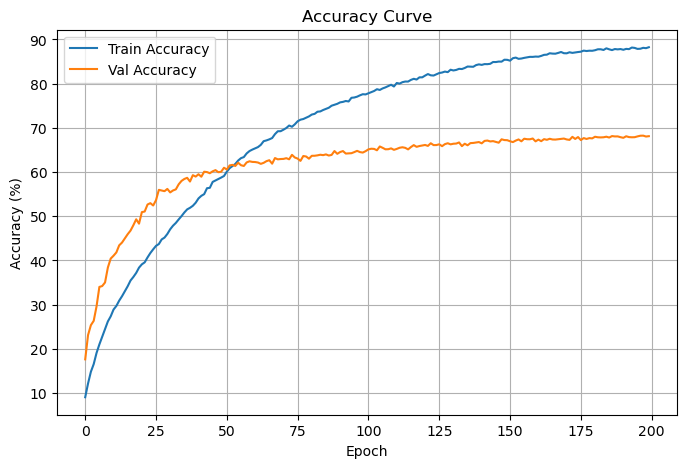

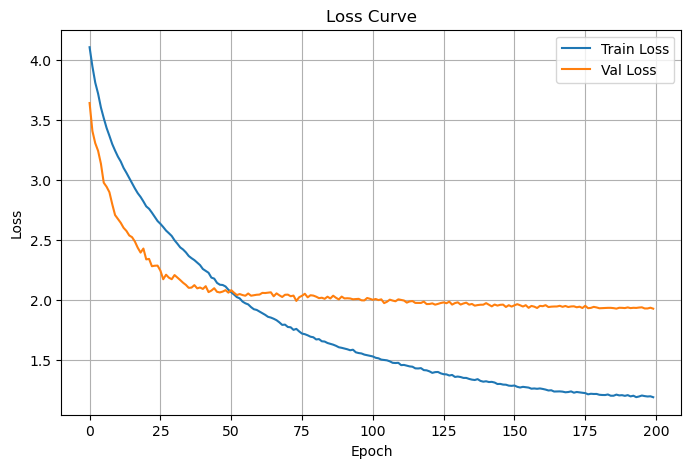

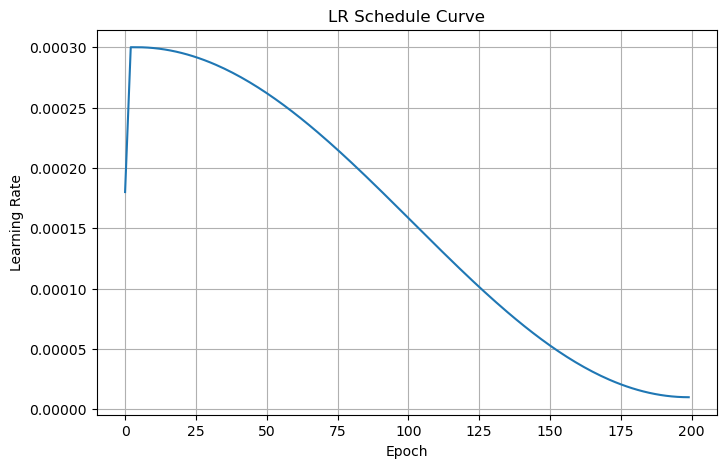

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("baseline_metrics.csv")

# Accuracy Curve
plt.figure(figsize=(8,5))
plt.plot(df["train_acc"], label="Train Accuracy")
plt.plot(df["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)
plt.savefig("baseline_accuracy_curve.png", dpi=300)
plt.show()

# Loss Curve
plt.figure(figsize=(8,5))
plt.plot(df["train_loss"], label="Train Loss")
plt.plot(df["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("baseline_loss_curve.png", dpi=300)
plt.show()

#  Learning Rate Schedule
plt.figure(figsize=(8,5))
plt.plot(df["lr"])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("LR Schedule Curve")
plt.grid(True)
plt.savefig("baseline_lr_curve.png", dpi=300)
plt.show()
